# Honor 3 高维数据可视化


除了一维、 二维、 三维以外, 高维数据的展示方法有：

* 增加视觉通道 (元素的位置, 大小, 颜色, 形状等)
* 增加多个视图
* 其它可视化方法
* 其它数据变换方法

代码参考链接 https://zhuanlan.zhihu.com/p/427788536 

## 高维可视化方法

### 雷达图

范例: [Plotly](https://plotly.com/python/radar-chart/) [Matplotlib](https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html) [Seaborn](https://aakashkh.github.io/python/visualisation/2019/08/26/Plotting-Seaborn-Radar.html)

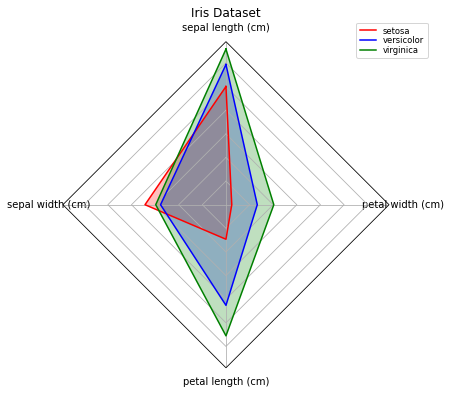

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    class RadarTransform(PolarAxes.PolarTransform):
        def transform_path_non_affine(self, path):
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):
        name = 'radar'
        PolarTransform = RadarTransform
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)
    register_projection(RadarAxes)
    return theta

from sklearn.datasets import load_iris
data_iris = load_iris()
theta = radar_factory(4, frame = 'polygon') # 4 is the dimension of factors
fig, axs = plt.subplots(figsize=(6, 6), nrows = 1, ncols = 1, subplot_kw=dict(projection='radar'))
ax = axs
for i, (classname, color) in enumerate(zip(data_iris['target_names'], 'rbgm')):
    mean_data = (data_iris['data']*(data_iris['target']==i).reshape((-1,1))).sum(axis=0) / (data_iris['target']==i).sum()
    ax.plot(theta, mean_data, color = color)
    ax.fill(theta, mean_data, facecolor=color, alpha=0.25, label='_nolegend_')
ax.set_varlabels(data_iris['feature_names'])
labels = data_iris['target_names']
legend = ax.legend(labels, loc=(0.9, .95), labelspacing=0.1, fontsize='small')
ax.yaxis.set_ticklabels([])
plt.title('Iris Dataset')
plt.show()

### Small Multiples

多画几个小图。


### 平行坐标

(parallel coordinate) 如下图每个数据是一条折线, 连接不同的维度的坐标. 由 Inselberg 发明. 缺点: 太乱.

[Pandas](https://zhuanlan.zhihu.com/p/427788536)

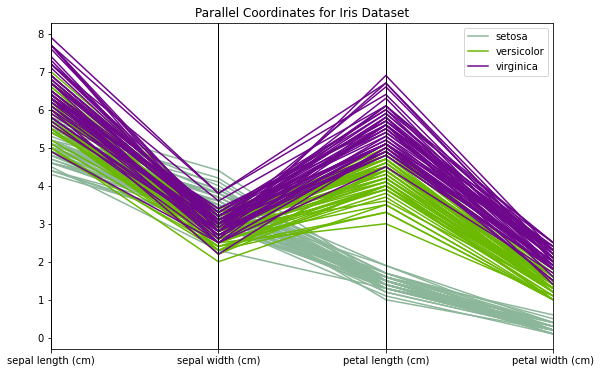

In [2]:
from pandas.plotting import parallel_coordinates
import pandas as pd
from sklearn.datasets import load_iris
data_iris = load_iris()
data_iris_pd = pd.DataFrame(dict([('class',data_iris['target_names'][data_iris['target']])]\
                         + list(zip(data_iris['feature_names'],data_iris['data'].T))))

plt.figure(figsize=(9, 6))
parallel_coordinates(data_iris_pd, 'class')
plt.title('Parallel Coordinates for Iris Dataset')
plt.grid(alpha = .3)
plt.show()

平行坐标可以重新排列数据轴.

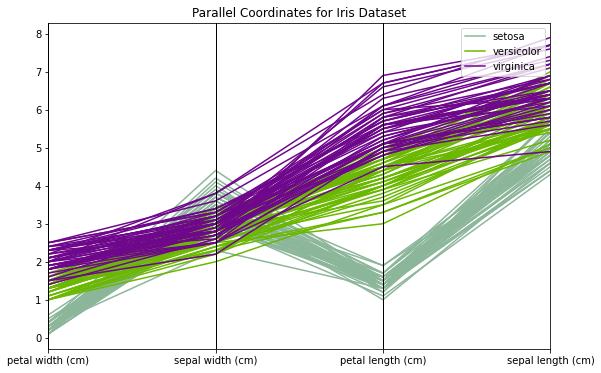

In [3]:
from pandas.plotting import parallel_coordinates
import pandas as pd
from sklearn.datasets import load_iris
data_iris = load_iris()
data_iris_pd = pd.DataFrame(dict([('class',data_iris['target_names'][data_iris['target']])]\
                         + [list(zip(data_iris['feature_names'],data_iris['data'].T))[i] for i in (3,1,2,0)]))

plt.figure(figsize=(9, 6))
parallel_coordinates(data_iris_pd, 'class')
plt.title('Parallel Coordinates for Iris Dataset')
plt.grid(alpha = .3)
plt.show()

平行坐标可以拓展到 parallel sets, SPPG 等.

### 切尔诺夫脸

(Chernoff face)

### 散点图矩阵

(scatterplot matrix) 很多个散点图放在一起. 缺点: 图太多看不完.

<Figure size 288x288 with 0 Axes>

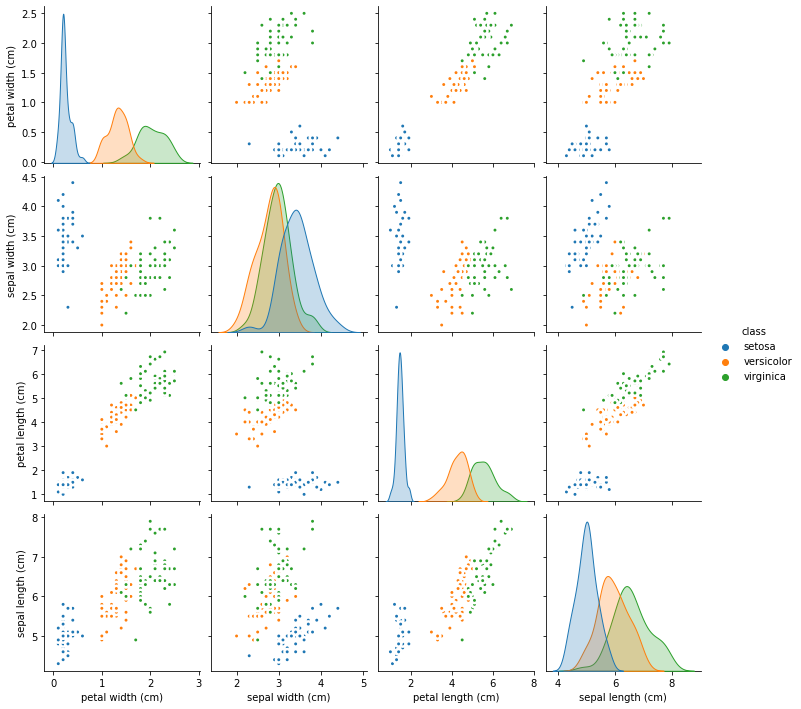

In [7]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
data_iris = load_iris()
data_iris_pd = pd.DataFrame(dict([('class',data_iris['target_names'][data_iris['target']])]\
                         + [list(zip(data_iris['feature_names'],data_iris['data'].T))[i] for i in (3,1,2,0)]))

plt.figure(figsize = (4, 4))
# around ten seconds
sns.pairplot(data_iris_pd, kind = 'scatter', hue = 'class', plot_kws=dict(s=30, linewidth=2.5))
plt.show()

## 高维数据变换

可以对数据降维再展示.

### 主成分分析

(principal component analysis, PCA) [sklearn PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA)

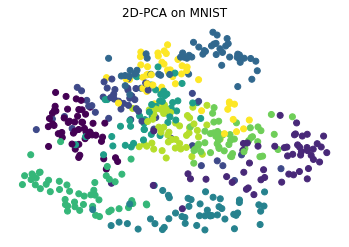

In [30]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.datasets import load_digits
mnist_x, mnist_y = load_digits(return_X_y=True)  # mnist_x shape: (1797, 64)
# from tensorflow.keras.datasets import mnist    # full version
# (mnist_x, mnist_y) , (_, __) = mnist.load_data()

mnist_x = mnist_x.reshape((mnist_y.size, -1)).astype('float') / (mnist_x.max() / 2.) - 1.
mnist_x -= mnist_x.mean(axis = 0) # centralize

# too many data will entangle and be hard to observe
mnist_x_2d = PCA(n_components=2).fit_transform(mnist_x[:500])

plt.scatter(mnist_x_2d[:,0], mnist_x_2d[:,1], c = mnist_y[:mnist_x_2d.shape[0]])
plt.title('2D-PCA on MNIST')
plt.axis('off')
plt.show()

### 多维尺度分析

(multidimensional scaling, MDS) [sklearn MDS](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html?highlight=mds#sklearn.manifold.MDS)

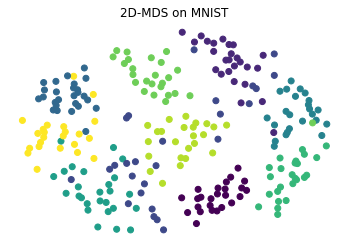

In [33]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.manifold import MDS
from sklearn.datasets import load_digits
mnist_x, mnist_y = load_digits(return_X_y=True)  # mnist_x shape: (1797, 64)

mnist_x = mnist_x.reshape((mnist_y.size, -1)).astype('float') / (mnist_x.max() / 2.) - 1.
mnist_x -= mnist_x.mean(axis = 0) # centralize

# MDS is much much much slower than PCA! So we use only 250 data.
mnist_x_2d = MDS(n_components=2).fit_transform(mnist_x[:250])

plt.scatter(mnist_x_2d[:,0], mnist_x_2d[:,1], c = mnist_y[:mnist_x_2d.shape[0]])
plt.title('2D-MDS on MNIST')
plt.axis('off')
plt.show()

### 非负矩阵分解

(nonnegative matrix factorization, NMF)

### t-SNE

将数据降到低维但保持各点之间的相似度的概率分布. t-SNE 是无监督聚类.

注意: 1. 不能比较簇间距离. 2. 需要设置超参数混乱度 (perplexity).

[sklearn TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

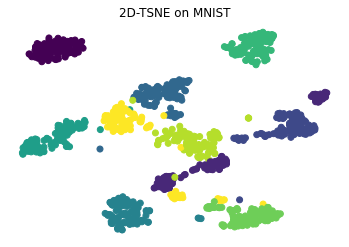

In [40]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
mnist_x, mnist_y = load_digits(return_X_y=True)  # mnist_x shape: (1797, 64)

mnist_x = mnist_x.reshape((mnist_y.size, -1)).astype('float') / (mnist_x.max() / 2.) - 1.
mnist_x -= mnist_x.mean(axis = 0) # centralize

# TSNE: faster than MDS and better than MDS
mnist_x_2d = TSNE(n_components=2, perplexity = 30.).fit_transform(mnist_x[:1000])

plt.scatter(mnist_x_2d[:,0], mnist_x_2d[:,1], c = mnist_y[:mnist_x_2d.shape[0]])
plt.title('2D-TSNE on MNIST')
plt.axis('off')
plt.show()